In [11]:
# Imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
from matplotlib.ticker import FuncFormatter

In [12]:
# Set seaborn style
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette(cc.glasbey_category10, n_colors=25)

## Figure 4: Agent Importance on deterministic LBF task

In [13]:
# Read in data
data_path = "minimal_experiment_data/"
exp_name = "deterministic_lbf_exps"

path_use = data_path + exp_name

# Set name of the task to plot. 
filter_task_name = "lbforaging:Foraging-15x15-3p-3f-det-max-food-sum-v2"

json_files = []
for root, dirs, files in os.walk(path_use):
    if "master_agent_importance.json" in files and (filter_task_name in root):
        json_files.append(os.path.join(root, "master_agent_importance.json"))

In [14]:
# Store the data from multiple independent runs

main_data = {
    "iql_data": {},
    "maa2c_data": {},
    "mappo_data": {},
    "qmix_data": {},
    "vdn_data": {},
    "iql_ns_data": {},
    "maa2c_ns_data": {},
    "mappo_ns_data": {},
    "qmix_ns_data": {},
    "vdn_ns_data": {},
}

In [15]:
def get_data(json_path, algorithm):
    with open(json_path, "r") as file:
        data = json.load(file)

    algorithm_name = algorithm + "_data"

    agent_keys = [
        k for k in data[list(data.keys())[0]].keys() if k.endswith("_importance_value")
    ]

    agent_values = {key: [] for key in agent_keys}

    for time_step in data.keys():
        for agent_key in agent_keys:
            if data[time_step][agent_key]:
                agent_values[agent_key].append(data[time_step][agent_key])

    window_size = 30

    for agent_key in agent_keys:
        if agent_key not in main_data[algorithm_name]:
            main_data[algorithm_name][agent_key] = []
        mean_values = [np.mean(val) for val in agent_values[agent_key]]
        smoothed_values = (
            pd.Series(mean_values)
            .rolling(window=window_size, min_periods=1, center=True)
            .mean()
            .to_numpy()
        )

        main_data[algorithm_name][agent_key].append(smoothed_values)


for json_path in tqdm(json_files, desc="Processing JSON files"):
    json_folder = os.path.dirname(json_path)
    algorithm, env_name, seed, metric = json_folder.split("/")[-4:]
    task_name = env_name.split(":")[1]
    seed = int(seed)

    get_data(json_path, algorithm)

Processing JSON files: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


In [16]:
# Order of magnitude values for scaling the y-axis values
format_ranges = {
    "iql_data": 3,
    "maa2c_data": 2,
    "mappo_data": 2,
    "qmix_data": 3,
    "vdn_data": 3,
    "iql_ns_data": 3,
    "maa2c_ns_data": 2,
    "mappo_ns_data": 2,
    "qmix_ns_data": 3,
    "vdn_ns_data": 3,
}

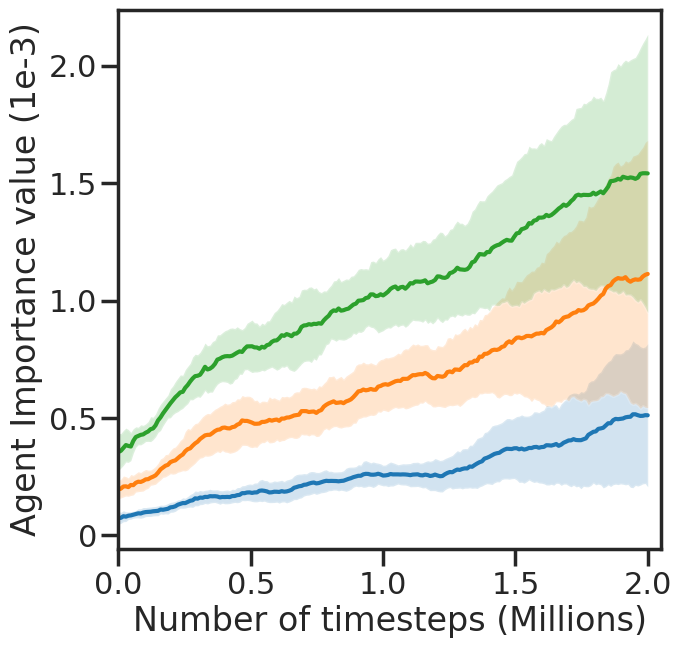

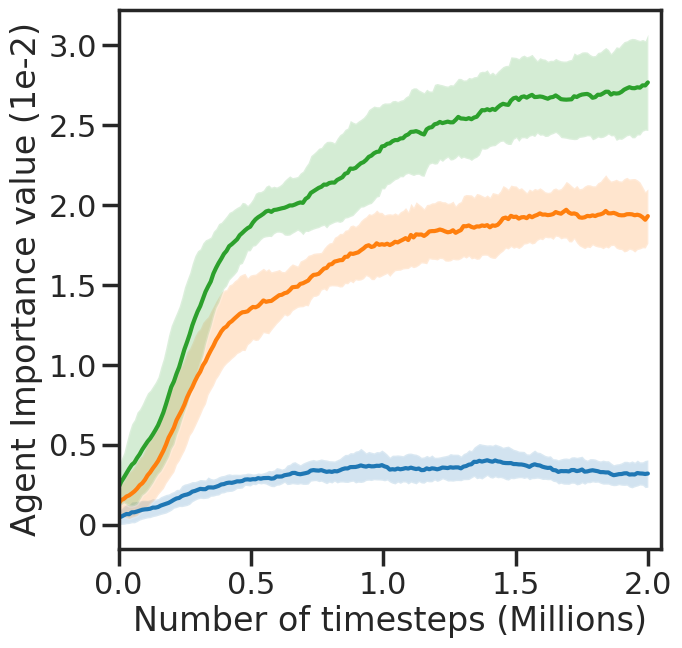

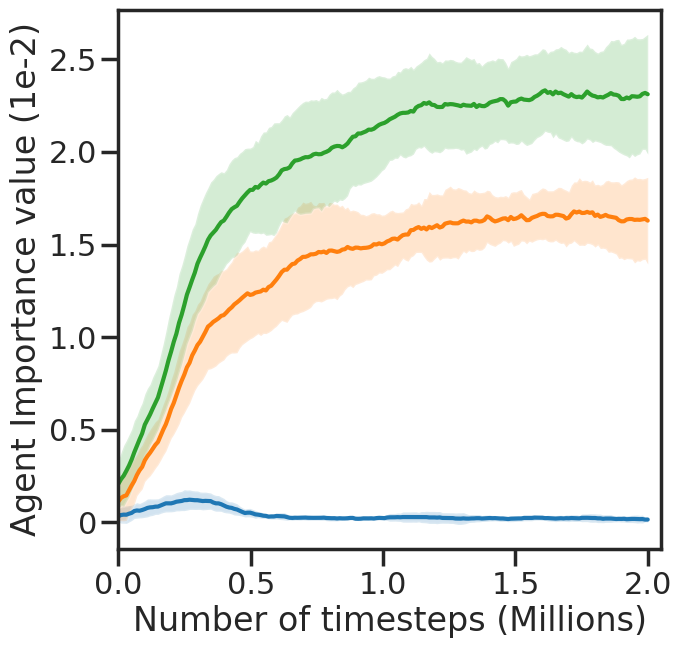

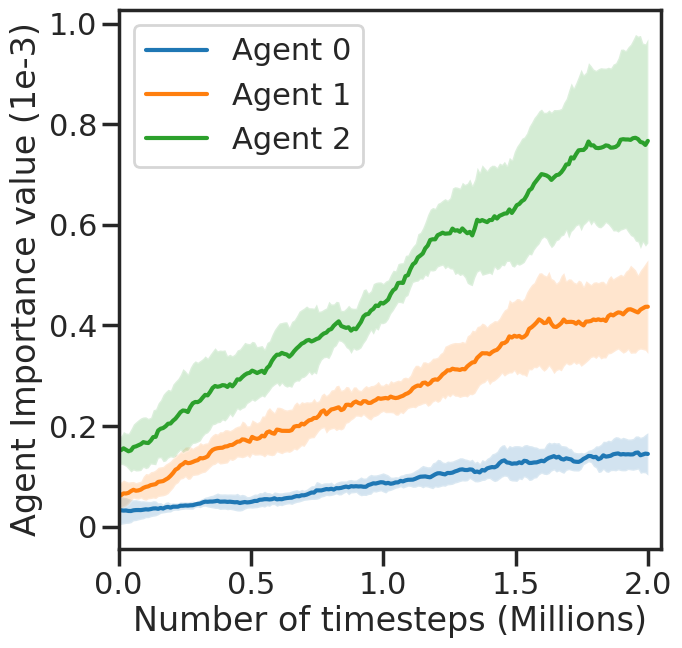

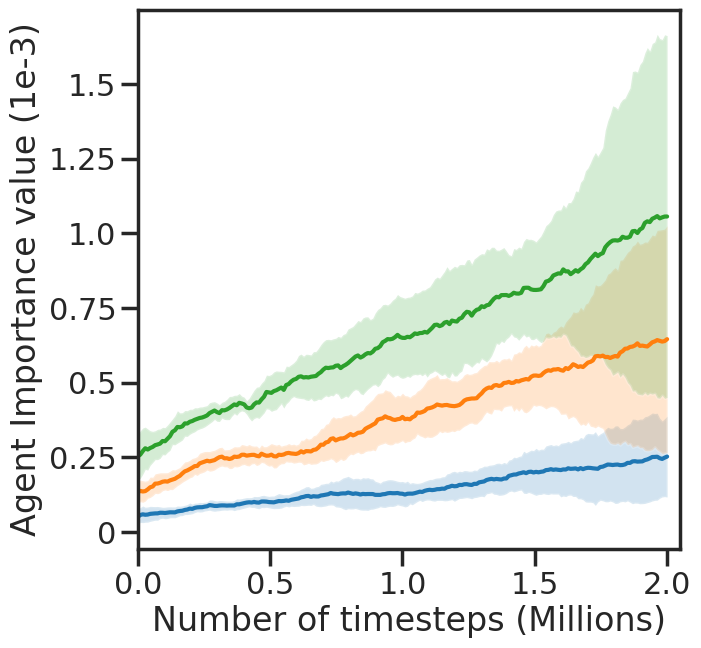

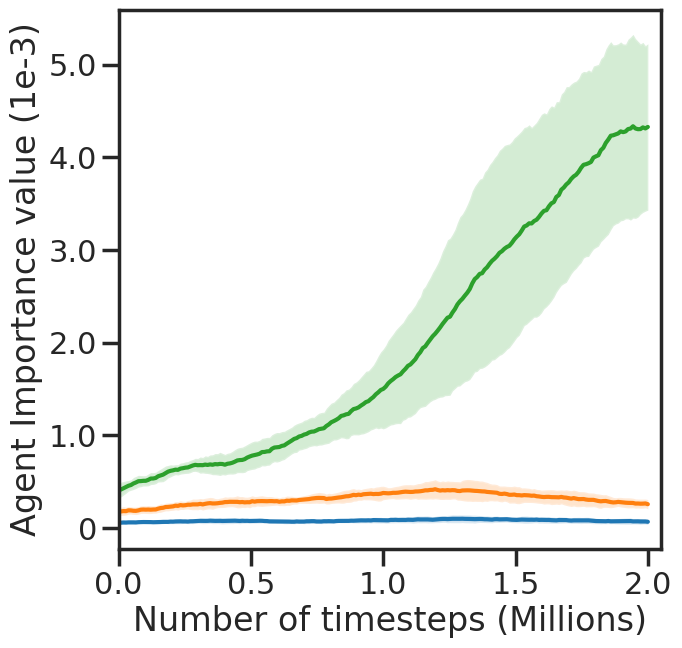

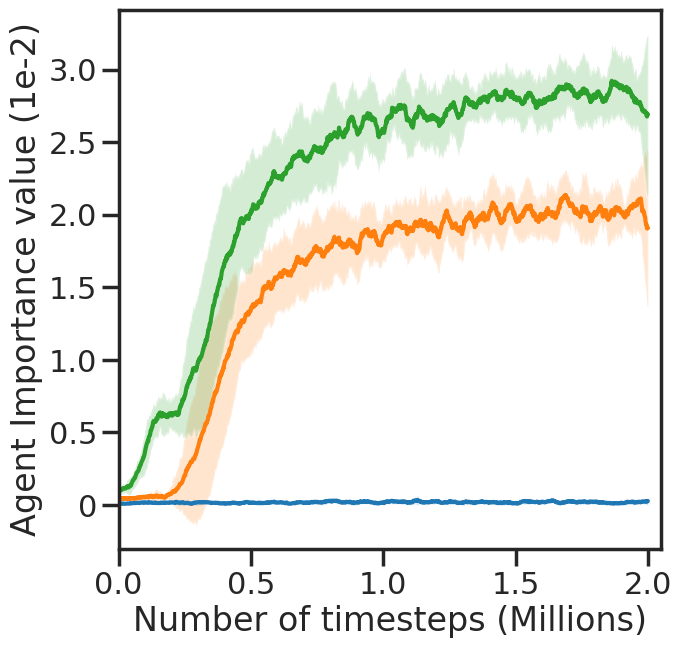

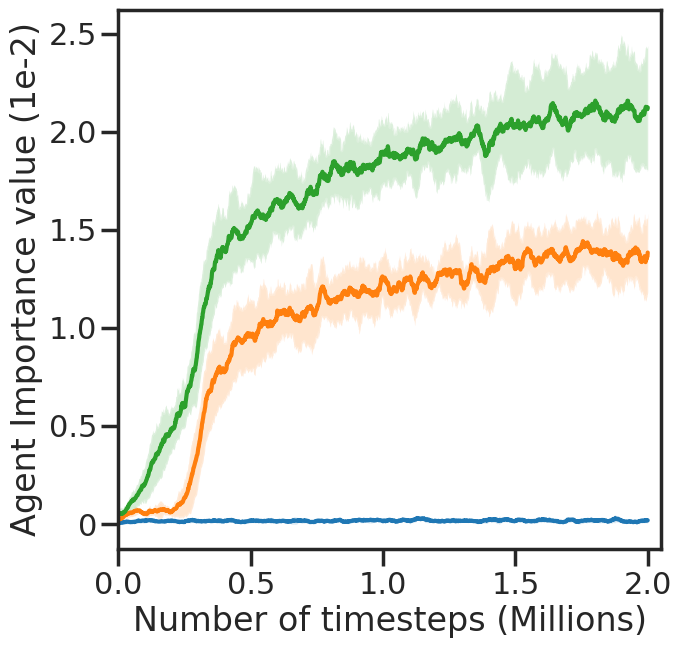

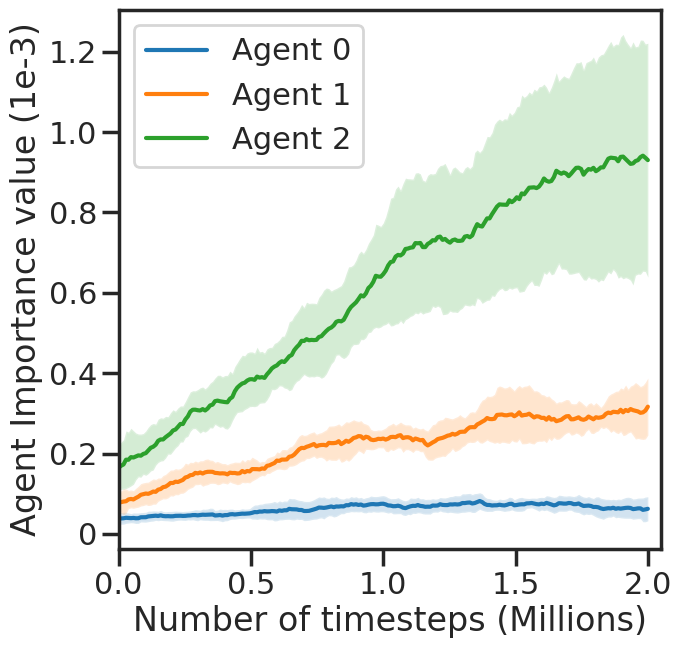

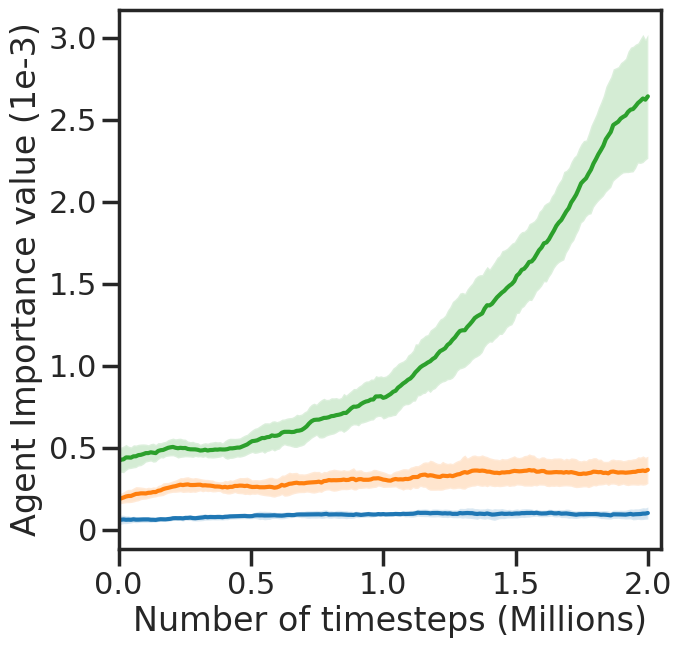

In [17]:
for algorithm, algorithm_data in main_data.items():
    fig, ax = plt.subplots(figsize=(7, 7))  # Change the size as per your need

    # First find the minimum length across all series
    min_length = min(
        [len(v) for agent, values in algorithm_data.items() for v in values]
    )

    for agent, values in algorithm_data.items():
        # Slice all series to have the min length
        values = [v[:min_length] for v in values]

        agent_number = agent.split("_")[1]
        values_array = np.array(values)
        mean_values = np.mean(values_array, axis=0)
        std_values = np.std(values_array, axis=0)

        time_steps = range(len(mean_values))

        ax.plot(
            np.linspace(0, 2, len(mean_values)),
            mean_values,
            label=f"Agent {agent_number}",
        )
        ax.fill_between(
            np.linspace(0, 2, len(mean_values)),
            mean_values - std_values,
            mean_values + std_values,
            alpha=0.2,
        )

    ax.set_xlabel("Number of timesteps (Millions)")
    ax.set_xlim(0, 2.05)
    ax.set_xticks(np.arange(0, 2.5, 0.5))
    ax.set_ylabel(f"Agent Importance value (1e-{format_ranges[algorithm]})")
    formatter = FuncFormatter(
        lambda x, _: round((x * (10 ** format_ranges[algorithm])), 2) if x != 0 else "0"
    )
    ax.yaxis.set_major_formatter(formatter)

    if algorithm == "qmix_data":
        ax.legend()
    if algorithm == "qmix_ns_data":
        ax.legend()

    plt.show()